# Model Misspecification in SBI

In this tutorial, we would describe how to detect prior misspecification, one instance of model misspecification in Simulation-based Inference (SBI), and demonstrate it on two simulators: a toy 2d Gaussian mean inference task, and the [Hodgkin-Huxley
model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model) from neuroscience. General familiarity with the SBI toolkit will be assumed. Note that other forms of model misspecification such as misspecified likelihood or presence of noise are also prevalent in the SBI literature [1], but the scope of this tutorial would be limited to prior misspecification.

In general we want to investigate if a observation $x_o$ is coming from the same distribution as the output distribution of the simulator $p(x) = \int p(x| \theta) p(\theta)d\theta$, where $p(\theta)$ is our prior distribution. 
There could be a mismatch on multiple levels: a wrongly specified likelihood model $p(x|\theta)$, or a mismatched prior. In this tutorial we will focus on a misspecified prior, but the workflow is the same for other sources of misspecification as we compare always $x_o$ vs $p(x)$.

We will guide you through the following sections:
1. Model misspecification for a 2d Gaussian toy example\
    a) in the embedding space $e(x)$ via MMD\
    b) for an unconditional trained density estimator $p(x)$

2. Model misspecification for the Hodgkin-Huxley model:\
    a) in the data space via MMD\
    b) with summary statistics via MMD\
    c) in the embedding space $e(x)$ via MMD\
    d) for an unconditional trained density estimator $p(x)$ *(Null result)*


References:
- [1] [Schmitt et al, 2024](https://arxiv.org/abs/2112.08866)
- [2] [Gretton et al, 2012](https://www.jmlr.org/papers/volume13/gretton12a/gretton12a.pdf)


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist

from sbi.diagnostics.misspecification import (
    calc_misspecification_mmd,  # Import the MMD diagnostic
    log_prob_hypothesis_test,  # Import the log-prob diagnostic
)
from sbi.inference import NPE
from sbi.inference.trainers.marginal import MarginalTrainer
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import FCEmbedding
from sbi.utils.metrics import c2st

# Set seed
seed = 2025
torch.manual_seed(seed)

In [2]:
# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

## 1. 2D Gaussian Simulator

In this example, we work with the following simulator: the prior $\theta \sim \mathcal{N}(0, I_d)$, and the observations $x|\theta \sim \mathcal{N}(\theta, I_d)$, where $d$ is the dimensionality of the problem. For the purposes of this example, we would assume the observations, i.e., $x_o$ would come from the (true) data generating process above.

Now we demonstrate a concrete example of model misspecification scenario in SBI. We assume our posterior inference network (e.g., NPE) would be fitted on $(\theta, x)$ pairs where the $\theta$ values are sampled from $\mathcal{N}(\mu, I_d)$ (instead of $\mathcal{N}(0, I_d)$, i.e., with some offset mean $\mu$), and the corresponding observations $x$ were generated using the simulator as above. We refer to this manifestation of model misspecification as **prior misspecification**, and demonstrate how we can identify this using (one or many) observations $x_o$ during test time, following the maximum mean discrepancy (MMD) based approach outlined in [1]. 

The core idea of the method is to compute a distribution of MMD values among the synthetic simulations ($x$) the model was trained on, and perform an out-of-distribution/p-value check for the MMD between the synthetic simulations and the $x_o$. Since we will often encounter only one observation $x_o$ during inference, we would make use of the biased version of sample-based MMD recommended in [2].

#### Define the ground-truth and misspecified priors
The "ground-truth" prior simply means the $x_{obs}$ will come from this prior distribution through the simulator.
The misspecified prior: the NPE will be trained on $(\theta, x)$ pairs coming from this prior. Note that the simulator code is same in both cases.

In [3]:
dim = 2  # observation dimension
# true prior -- the observation comes from here
mean_true = torch.zeros(dim)
cov_true = torch.eye(dim)
prior_true = dist.MultivariateNormal(loc=mean_true, covariance_matrix=cov_true)


# the NPE will be trained on samples from this misspecified prior
def give_misspec_prior(mu0, tau0):
    if mu0.ndim > 1:
        raise ValueError("mu0 should be a 1d tensor of shape [dim]")
    dim = mu0.shape[0]
    return dist.MultivariateNormal(loc=mu0, covariance_matrix=tau0 * torch.eye(dim))


offset = 4
mu0 = mean_true + offset  # just offset, applies in all directions
tau0 = 1.0  # 1.0 means no change in covariance matrix
prior_mis = give_misspec_prior(mu0, tau0)


def simulator(theta):
    return theta + torch.randn_like(theta)

#### Create the training dataset for the NPE, i.e., $(\theta, x)$ pairs
As we will see later, we can only train one NPE on the well-specified dataset, and simulate the other scenarios exploiting the symmetry present in our setting.
We will also generate a validation dataset, to compute many _self_ MMDs or the distribution of MMDs which will be utilised later for the actual misspecification check.

In [4]:
num_simulations = 1000

# generate training data for clean/well-specified model
theta_well = prior_true.sample((num_simulations,))
x_well = simulator(theta_well)


# validation set to compute MMD distribution in the well-specified case
# this could just be a subset of the training data

num_validations_mmd = 1000
theta_val_well = prior_true.sample((num_validations_mmd,))
x_val_well = simulator(theta_val_well)

print(theta_well.shape, theta_val_well.shape)

torch.Size([1000, 2]) torch.Size([1000, 2])


### a) Detecting misspecification in the embedding space

#### Train our inference object
We are only training one NPE inference with an embedding network to demonstrate the MMD-based misspecification check both on the original _x-space_ and the _embedding_ space.

In [5]:
def train_npe_with_embedding(theta, x, prior, embeddding_net, **kwargs):
    neural_posterior = posterior_nn(model="maf", embedding_net=embeddding_net)
    inference = NPE(prior=prior, density_estimator=neural_posterior, **kwargs)
    inference = inference.append_simulations(theta, x)
    _ = inference.train()
    return inference


emb_net_well = FCEmbedding(
    input_dim=dim, output_dim=dim, num_layers=2, num_hiddens=20
)  # minimal embedding network
NPE_well_embd = train_npe_with_embedding(
    theta_well, x_well, prior=prior_true, embeddding_net=emb_net_well
)  # modified the emb_net

 Neural network successfully converged after 199 epochs.

#### Create the observations $x_{obs}$ to do inference
We will generate two observations: one from the ground-truth prior to demonstrate the case where we **do not** have any model misspecification. The second observation will be generated from the misspecified prior to _simulate_ the model misspecification scenario when our inference was trained on the misspecified data, but the observation comes from the ground-truth prior. 

In [6]:
# do inference given observed data
num_observations = 1
theta_o = prior_true.sample((num_observations,))
x_o = simulator(theta_o)

# we can also create observation from the misspecified prior x_o_mis
theta_o_mis = prior_mis.sample((num_observations,))
x_o_mis = simulator(theta_o_mis)

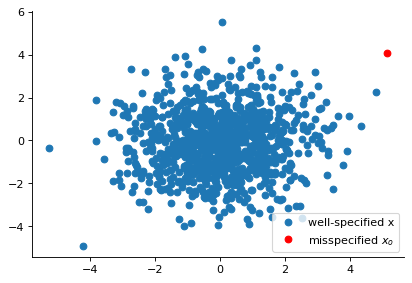

In [7]:
plt.figure(figsize=(6, 4), dpi=80)
plt.plot(x_val_well[:, 0], x_val_well[:, 1], "o", label="well-specified x")
plt.plot(x_o_mis[:, 0], x_o_mis[:, 1], "o", color="red", label=r"misspecified $x_o$")
plt.legend(loc="lower right")
plt.show()

Here we only demonstrate misspecification detection on the embedding space. Note that the corresponding scenarios on the x-space could be simply tested by passing `inference=None` and `mode=x_space` in the functions below.

The primary interface to detect prior misspecification is through the `calc_misspecification_mmd()` function that expects the following arguments:
- `inference` object: this is the trained NPE object with or without embedding network
- `x_obs`: the actual observation, we detect whether this observation is misspecified with respect to the distribution seen by the NPE object during training
- `x`: a reference validation set of synthetic observations from the training distribution, this could in principle be a separated out subset of the training observations,
but here we choose to pass a validation set
- `mode`: whether to compute the mmds in the embedding space (`embedding`) or the original observation space (`x_space`).

The function returns `p-value` of the test, along with a tuple of the reference/baseline mmds and the mmd between `x_obs` and the validation set `x`. We can simply inspect the `p-value` and also visualize the distribution as done below:

p-val: 0.501000


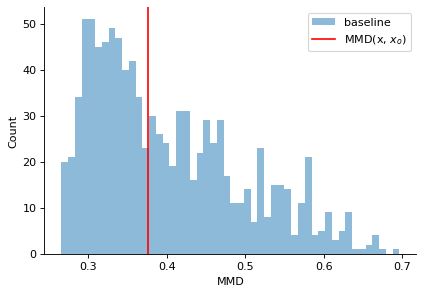

In [8]:
p_val, (mmds_baseline, mmd) = calc_misspecification_mmd(
    inference=NPE_well_embd, x_obs=x_o, x=x_val_well, mode="embedding"
)

print(f"p-val: {p_val:.6f}")

plt.figure(figsize=(6, 4), dpi=80)
plt.hist(mmds_baseline.numpy(), bins=50, alpha=0.5, label="baseline")
plt.axvline(mmd.item(), color="red", label=r"MMD(x, $x_o$)")
plt.ylabel("Count")
plt.xlabel("MMD")
plt.legend()
plt.show()

**Interpretation:** In the above example, the observed data $x_o$ comes from the same ground truth prior as what the NPE estimator was trained on. As detected by the check above, the $p$-value for the null hypothesis $H_0$ (that the distribution of MMDs between samples in `x_val_well` (intra) and the distribution of MMDs between `x_val_well` and `x_o` are same) came out to be $0.501 \gt 0.05$, so we fail to reject the null hypothesis, i.e., no misspecification is detected in this case.

Now we turn to the situation where there is a misspecification.

p-val: 0.0


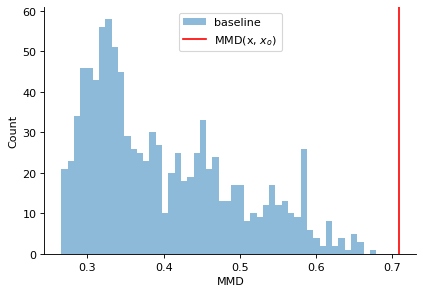

In [9]:
p_val, (mmds_baseline, mmd) = calc_misspecification_mmd(
    inference=NPE_well_embd, x_obs=x_o_mis, x=x_val_well, mode="embedding"
)

plt.figure(figsize=(6, 4), dpi=80)
print(f"p-val: {p_val}")
plt.hist(mmds_baseline.numpy(), bins=50, alpha=0.5, label="baseline")
plt.axvline(mmd.item(), color="red", label=r"MMD(x, $x_o$)")
plt.ylabel("Count")
plt.xlabel("MMD")
plt.legend()
plt.show()

As expected, in this case the $p$-value is $0.0$ so we reject the null hypothesis, and can warn the user that there might be mismatch in distribution between the observed sample $x_o$, and the dataset on which the inference network was trained on.

### b) Detecting misspecification with the marginal distribution $p(x)$

Now we illustrate another way to detect misspecification in the original observation space or `x-space` by computing log-probabilities using the unconditional flow based `MarginalTrainer` available in the `sbi` package. The core idea is to first fit a marginal density $q(x) \approx p(x)$ using the training observations `x`, and compare the log probability evaluations on a validation set and on the observed data `x_obs`. Finally, similar to the test for the MMD based detection, we also use a quantile-based hypothesis test on the log probabilities for the null hypothesis $H_0$ that `x_obs` comes from the same distribution as the training/validation data `x`.

For this we train an unconditional density estimator $q(x)$ on our training data $X$, e.g. ignoring the parameters $\theta$.

In [10]:
# we can reuse the training x-s here as well
num_training_marginal = 1000
theta_train = prior_true.sample((num_training_marginal, ))
x_train = simulator(theta_train)

# Instantiate a trainer for the marginal pdf and train it
trainer = MarginalTrainer(density_estimator='NSF')
print(f"Training marginal q(x) on {x_train.shape[0]} samples...")
trainer.append_samples(x_train)
est = trainer.train(max_num_epochs=3000)

# Sample from the approximate marginal pdf estimator q(x)
n_samples = 1_000
samples = est.sample((n_samples,))

# Compute the C2ST score
c2st_val = c2st(x_val_well, samples)
print(f"\nc2st: {c2st_val}")

Training marginal q(x) on 1000 samples...
 Training neural network. Epochs trained: 49
c2st: 0.533


We see that the fitted marginal estimator $q(x)$ has C2ST very close to $0.5$, so it is approximating the desired marginal distribution $p(x)$ well.
Now we turn to misspecification detection using this marginal estimator.

First we visualise the `log_prob`s for the training data, and the observed instances `x_o` (well-specified) and `x_o_mis` (misspecified).

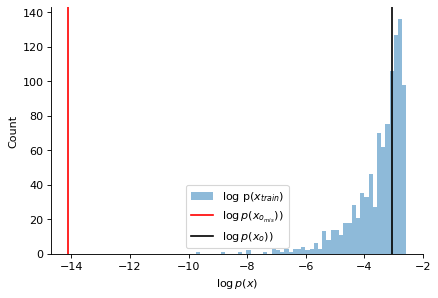

In [ ]:
plt.figure(figsize=(6, 4), dpi=80)
plt.hist(est.log_prob(x_train).detach().numpy(), bins=50, alpha=0.5, label=r'log p($x_{train}$)')
plt.axvline(est.log_prob(x_o_mis).detach().item(), color="red", label=r'$\log p(x_{o_{mis}})$)')
plt.axvline(est.log_prob(x_o).detach().item(), color="k", label=r'$\log p(x_o)$)')
plt.ylabel('Count')
plt.xlabel(r'$\log p(x)$')
plt.legend()
plt.show()

We can clearly see that the `log_prob` for the misspecified observation `x_o_mis` is far away from the `log_prob`s of the training data and also that of the well-specified sample `x_o`. We now perform the quantile-based hypothesis test.

In [12]:
# testing
log_probs_train = est.log_prob(x_train).detach()
log_prob_xo = est.log_prob(x_o).detach().item()
log_prob_xo_mis = est.log_prob(x_o_mis).detach().item()


p_value_well, reject_H0_well = log_prob_hypothesis_test(log_probs_train, log_prob_xo)
print(f"P-value: {p_value_well:.4f}")
print(f"Do we reject H0 for the well-specified obs x_o? {reject_H0_well}")


p_value_mis, reject_H0_mis = log_prob_hypothesis_test(log_probs_train, log_prob_xo_mis)
print(f"P-value: {p_value_mis:.4f}")
print(f"Do we reject H0 for the misspecified obs x_o_miss? {reject_H0_mis}")

P-value: 0.5980
Do we reject H0 for the well-specified obs x_o? False
P-value: 0.0000
Do we reject H0 for the misspecified obs x_o_miss? True


# Misspecification on Hodgkin-Huxley model: tutorial

In this tutorial, we will check model misspecification on a [Hodgkin-Huxley
model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model) from
neuroscience (Hodgkin and Huxley, 1952). 



Note, you find a tutorial on the HH model in the `sbi` repository under
[docs/tutorials/Example_00_HodgkinHuxleyModel.ipynb](https://github.com/sbi-dev/sbi/blob/main/docs/tutorials/Example_00_HodgkinHuxleyModel.ipynb).

Here we assume, that you are already familiar with the Hodgkin-Huxley model and the basic functionality of `sbi`.


First we are going to import basic packages.


In [11]:
%load_ext autoreload
%autoreload 2

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch

# HH simulator
from HH_helper_functions import HHsimulator, calculate_summary_statistics, syn_current

from sbi import analysis as analysis

# sbi
from sbi import utils as utils
from sbi.inference import simulate_for_sbi
from sbi.neural_nets.embedding_nets import FCEmbedding
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

# set seed
seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)

In [12]:
# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

## 2. Hodgkin-Huxley Model

Let us assume we current-clamped a neuron and recorded the following voltage trace:

<img src="https://raw.githubusercontent.com/mackelab/delfi/master/docs/docs/tutorials/observed_voltage_trace.png" width="480">
<br>



We would like to infer the posterior over the two parameters ($\color{orange}{\bar g_{Na}}$,$\color{orange}{\bar g_K}$) of a Hodgkin-Huxley model, given the observed electrophysiological recording above. The model has channel kinetics as in [Pospischil et al. 2008](https://link.springer.com/article/10.1007/s00422-008-0263-8), and is defined by the following set of differential equations (parameters of interest highlighted in orange):


$$
\scriptsize
\begin{align}
\color{black}{C_m\frac{dV}{dt}}& \color{black}{=g_1\left(E_1-V\right)}+
                    \color{orange}{\bar{g}_{Na}} \color{black}{m^3h\left(E_{Na}-V\right)+}
                    \color{orange}{\bar{g}_{K}} \color{black}{n^4\left(E_K-V\right)+\bar{g}_Mp\left(E_K-V\right)+I_{inj}+\sigma\eta\left(t\right)}\\
                    \color{black}{\frac{dq}{dt}}&\color{black}{=\frac{q_\infty\left(V\right)-q}{\tau_q\left(V\right)},\;q\in\{m,h,n,p\}}
\end{align}
$$


In [13]:
# current, onset time of stimulation, offset time of stimulation, time step, time, area of some
I_inj, t_on, t_off, dt, t, A_soma = syn_current()

In [14]:
def run_HH_model(params):

    params = np.asarray(params)

    # input current, time step
    I_inj, t_on, t_off, dt, t, A_soma = syn_current()

    t = np.arange(0, len(I_inj), 1) * dt

    # initial voltage V0
    initial_voltage = -70

    voltage_trace = HHsimulator(initial_voltage, params.reshape(1, -1), dt, t, I_inj)

    return dict(data=voltage_trace.reshape(-1), time=t, dt=dt, I_inj=I_inj.reshape(-1))

And for convenience we define the simulator to return only the voltage trace:

In [15]:
def simulator(params):
    """
    Returns only voltage trace
    """
    obs = run_HH_model(params)
    return torch.tensor(obs["data"], dtype=torch.float).reshape(1, -1)

To get an idea of the output of the Hodgkin-Huxley model, let us generate some voltage traces for different parameters ($\bar g_{Na}$,$\bar g_K$), given the input current $I_{\text{inj}}$:


In [16]:
# three sets of (g_Na, g_K)
params = np.array([[10.0, 5.0], [4.0, 1.5], [20.0, 10.0]])

num_samples = len(params[:, 0])
sim_samples = np.zeros((num_samples, len(I_inj)))
for i in range(num_samples):
    sim_samples[i, :] = run_HH_model(params=params[i, :])["data"]

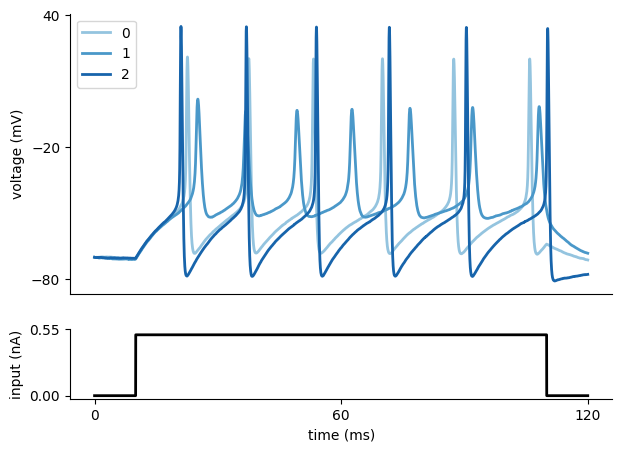

In [17]:
# colors for traces
col_min = 2
num_colors = num_samples + col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.0 * i / num_colors) for i in range(col_min, num_colors)]

fig = plt.figure(figsize=(7, 5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
# plot the three voltage traces for different parameter sets
for i in range(num_samples):
    plt.plot(t, sim_samples[i, :], color=col1[i], lw=2, label=i)
plt.legend()

plt.ylabel("voltage (mV)")
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

# plot the injected current
ax = plt.subplot(gs[1])
plt.plot(t, I_inj * A_soma * 1e3, "k", lw=2)
plt.xlabel("time (ms)")
plt.ylabel("input (nA)")

ax.set_xticks([0, max(t) / 2, max(t)])
ax.set_yticks([0, 1.1 * np.max(I_inj * A_soma * 1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))
plt.show()

### Prior over model parameters

Now that we have the simulator, we need to define a function with the prior over the model parameters ($\bar g_{Na}$,$\bar g_K$), which in this case is chosen to be a Uniform distribution:


> Note: This is where you would incorporate prior knowlegde about the parameters you want to infer, e.g., ranges known from literature. 


In [18]:
# well specified prior:
# prior_min = [0.5, 1e-4] # g_Na, g_K
# prior_max = [80.0, 15.0]

# misspecified prior:
prior_min = [0.5, 1e-4]
prior_max = [40.0, 5]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

In [19]:
# Generate training data

theta_train, x_train = simulate_for_sbi(
    simulator, proposal=prior, num_simulations=500, num_workers=4
)

100%|██████████| 500/500 [00:42<00:00, 11.86it/s]


Now let's sample two observations, which will play the role of the "experimental data" `x_o`.
The first one is coming from parameteres outside of the prior distribution and is therefore misspecified, the second one is a well specified sample.

In [20]:
# Generate misspecified sample
params_mis = np.array([70, 15])
x_o_mis = torch.tensor(
    run_HH_model(params=params_mis)["data"], dtype=torch.float
).reshape(1, -1)

# well specified
params_o = np.array([10, 4])
x_o = torch.tensor(run_HH_model(params=params_o)["data"], dtype=torch.float).reshape(
    1, -1
)

Let's have a quick look how these look like, compared to prior predictive samples.

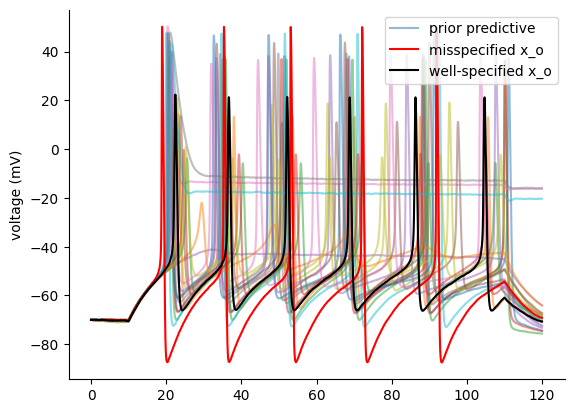

In [21]:
plt.plot(t, x_train[0:1, :].T, alpha=0.5, label="prior predictive")
plt.plot(t, x_train[1:20, :].T, alpha=0.5)
plt.ylabel("voltage (mV)")
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])
plt.plot(t, x_o_mis[0], color="red", label="misspecified x_o")
plt.plot(t, x_o[0], color="black", label="well-specified x_o")
plt.legend()

plt.show()

### a) Misspecification on raw data

In [22]:
from sbi.diagnostics.misspecification import calc_misspecification_mmd

Let's first check the well specified observation `x_o`:

In [23]:
p_val, (mmds_baseline, mmd) = calc_misspecification_mmd(
    x_obs=x_o,
    x=x_train,
    n_shuffle=1_000,
    max_samples=1_000,
)

print(f"p-value: {p_val}")

p-value: 0.779


Now let's check the misspecified observation `x_o_mis`:

In [24]:
p_val_mis, (_, mmd_mis) = calc_misspecification_mmd(
    x_obs=x_o_mis,
    x=x_train,
    n_shuffle=1_000,
    max_samples=1_000,
)

print(f"p-value: {p_val_mis}")

p-value: 0.0


This indicates that the observed value `x_o_mis` is very unlikely under the null hypothesis, which states that that the observation is coming from the true data distribution $p(x)$.

We can therefore reject $H_0$ and have evidence that `x_o_mis` is coming from a different distribution, e.g. our model is misspecified (in this case in terms of the prior distribution).

### b) Misspecification based on summary statistics

Now, as many neuroscientists work on summary statistics for the Hodgking Huxley model, let's do the same analysis on the summarized data.

Let's first define an augmented simulator which returns the summary statistics directly and then do the same steps as before:

In [25]:
def simulator_sumstats(params):
    """
    Returns summary statistics from conductance values in `params`.

    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats


# Check prior, simulator, consistency
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator_sumstats = process_simulator(simulator_sumstats, prior, prior_returns_numpy)
check_sbi_inputs(simulator_sumstats, prior)

In [ ]:
# Generate training data
theta_train_sumstats, x_train_sumstats = simulate_for_sbi(
    simulator_sumstats, proposal=prior, num_simulations=500, num_workers=4
)

100%|██████████| 1000/1000 [01:25<00:00, 11.64it/s]


In [27]:
# Generate misspecified sample
params_mis = np.array([70, 15])
x_raw = run_HH_model(params=params_mis)
x_o_mis_sumstats = torch.as_tensor(
    calculate_summary_statistics(x_raw), dtype=torch.float
).reshape(1, -1)


# and well specified
params_o = np.array([10, 4])
x_raw = run_HH_model(params=params_o)
x_o_sumstats = torch.as_tensor(
    calculate_summary_statistics(x_raw), dtype=torch.float
).reshape(1, -1)

Let's again first look at the well specified observation:

In [88]:
p_val, (mmds_baseline, mmd) = calc_misspecification_mmd(
    x_obs=x_o_sumstats,
    x=x_train_sumstats,
    n_shuffle=1_000,
    max_samples=1_000,
)

print(f"p-value: {p_val}")

p-value: 0.727


All good here...

Now the misspecified observation:

In [89]:
p_val_mis, (mmds_baseline, mmd) = calc_misspecification_mmd(
    x_obs=x_o_mis_sumstats,
    x=x_train_sumstats,
    n_shuffle=1_000,
    max_samples=1_000,
)

print(f"p-value: {p_val_mis}")

p-value: 0.15600000000000003


Interestingly, we can not reject $H_0$ in this case, although visually the traces look quite different. 
This is potentially due to the choice of summary statistics together with the fact that we only have tested one single observation `x_o_mis`.

Let's see if this changes, when we have two samples from the true data distribution: $X_o = \{x_{o_1}, x_{o_2}\}$:

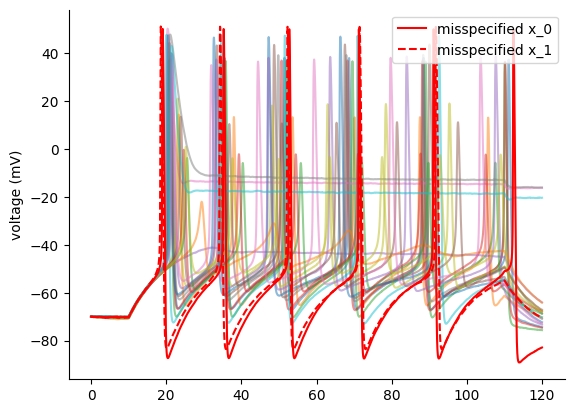

In [30]:
# Generate two misspecified samples and plot them
params_mis_mult = np.array([[70, 15], [78, 10]])
x_raw = []
x_o_mis_sumstats_mult = []
for i in range(len(params_mis_mult)):
    x_raw.append(run_HH_model(params=params_mis_mult[i]))
    x_o_mis_sumstats_mult.append(calculate_summary_statistics(x_raw[i]))
x_o_mis_sumstats_mult = torch.as_tensor(
    np.array(x_o_mis_sumstats_mult), dtype=torch.float
).reshape(-1, 7)

# plot them
plt.plot(t, x_train[:20, :].T, alpha=0.5)
plt.ylabel("voltage (mV)")
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])
lines = ["-", "--"]
for i in range(len(params_mis_mult)):
    plt.plot(
        t,
        np.array(x_raw[i]["data"]),
        color="red",
        label=f"misspecified x_{i}",
        ls=lines[i],
    )

plt.legend()

plt.show()

In [31]:
p_val_mis, (mmds_baseline, mmd) = calc_misspecification_mmd(
    x_obs=x_o_mis_sumstats_mult,
    x=x_train_sumstats,
    n_shuffle=10_000,
)

print(f"p-value: {p_val_mis}")

p-value: 0.012700000000000045


In this case the misspecification is detected. 

### c) Misspecification in the embedding space

Instead of using handcrafted summary statistics we can also use an embedding net $e$ and investigate if the embedded data $z=e(x)$ is misspecified. This idea was used in Schmitt et al. (https://arxiv.org/abs/2406.03154, where they additionally included a regularizer to the embedding space. Instead we will just use the standard training objective of NPE to optimize the embedding network. 

We therefore first have to run inference, to train the embedding net. 
In this toy example we will use a fully connected embeddding network to reduce the dimensionality of the voltage traces. 

We will use the same training data as in a).

In [32]:
# train NPE networks
torch.manual_seed(13)
emb_net = FCEmbedding(
    input_dim=x_train.shape[1], output_dim=20, num_layers=4, num_hiddens=50
)  # minimal embedding network
neural_posterior = posterior_nn(model="maf", embedding_net=emb_net)
inference = NPE(prior=prior, density_estimator=neural_posterior)
inference = inference.append_simulations(theta_train, x_train)
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 68 epochs.

Let's have a superficial check, if the network learned something meaningful. 
For this we will look at the posterior of the well specified observation `x_o`.

Drawing 10000 posterior samples for 1 observations: 10062it [00:00, 194385.73it/s]           
/var/folders/kx/9z7xgc9916l5ztl7kgxlydkm0000gn/T/ipykernel_31748/1311259568.py:2: DeprecationWarning: you passed deprecated arguments **kwargs: ['title', 'points_offdiag', 'points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = analysis.pairplot(


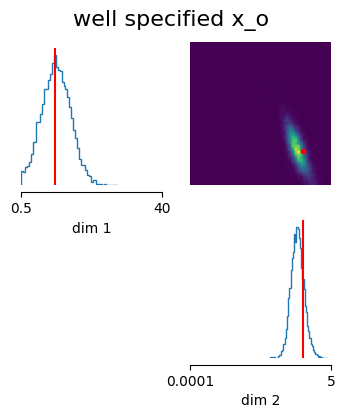

In [33]:
samples = posterior.sample((10000,), x=x_o)
fig, axes = analysis.pairplot(
    samples,
    title="well specified x_o",
    limits=[[prior_min[0], prior_max[0]], [prior_min[1], prior_max[1]]],
    ticks=[[prior_min[0], prior_max[0]], [prior_min[1], prior_max[1]]],
    figsize=(4, 4),
    points=params_o,
    points_offdiag={"markersize": 6},
    points_colors="r",
    # labels=labels_params,
)

# prior_min = [0.5, 1e-4]
# prior_max = [40.0, 5]

Drawing 10000 posterior samples for 1 observations: 10787it [00:00, 193225.56it/s]           
/var/folders/kx/9z7xgc9916l5ztl7kgxlydkm0000gn/T/ipykernel_31748/3696200400.py:2: DeprecationWarning: you passed deprecated arguments **kwargs: ['title', 'points_offdiag', 'points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = analysis.pairplot(


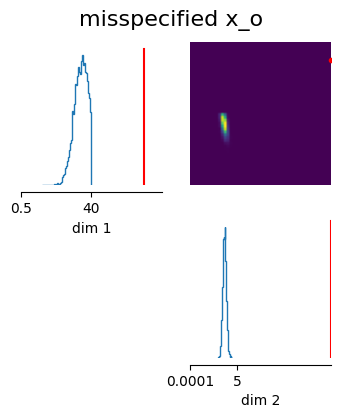

In [34]:
samples = posterior.sample((10000,), x=x_o_mis)
fig, axes = analysis.pairplot(
    samples,
    title="misspecified x_o",
    limits=[[0.5, 80], [1e-4, 15.0]],
    ticks=[[0.5, prior_max[0], 80], [1e-4, prior_max[1], 15.0]],
    figsize=(4, 4),
    points=params_mis,
    points_offdiag={"markersize": 6},
    points_colors=["r", "black"],
    # labels=labels_params,
)

Obviously, sbi can not infere the true parameters, because they are outside of the support of the prior distribution. sbi is however not failing, but infering some distribution. 

As we have trained an embedding net within the inference object, we can use this to detect misspecification in the embedding space:

In [35]:
# perform two tests for misspecification
# 1. well specified model
p_val_well, _ = calc_misspecification_mmd(
    x_obs=x_o,
    x=x_train,
    inference=inference,
    mode="embedding",
)
print(f"p-value well specified: {p_val_well}")

# 2. misspecified model
p_val_mis, (mmds_baseline, mmd) = calc_misspecification_mmd(
    x_obs=x_o_mis,
    x=x_train,
    inference=inference,
    mode="embedding",
)
print(f"p-value misspecified: {p_val_mis}")

p-value well specified: 0.754
p-value misspecified: 0.0


In this case we can egain detect the misspecification, however as we have note regularized our embedding space, the result should be treated with caution.  

### d) Detecting misspecification with a marginal density estimator 

First we need to import the marginal estimator:

In [100]:
from sbi.diagnostics.misspecification import log_prob_hypothesis_test
from sbi.inference.trainers.marginal import MarginalTrainer
from sbi.utils.metrics import c2st

Then we train the estimator for the marginal distribution $p(x_{train})$.

However, in this case we enconter two problems: Firstly, the $x$-space is 12.001 dimensional, so there is no way to estimate $p(x_{train})$ with only some hundreds, or thousands samples. 
So we turn to the summary statistics here, and want to learn the marginal distribution over the summary statistics: $p(s(x_{train}))$, where $s$ reduces the data into the 7 dimensional summary statistics space. In this space we can train the marginal estimator:

In [94]:
# Instantiate a trainer for the marginal pdf and train it
trainer = MarginalTrainer(density_estimator="NSF")
trainer.append_samples(x_train_sumstats)
est = trainer.train(max_num_epochs=3000)

 Training neural network. Epochs trained: 368

So let's check how good this approximation is by calculating the `c2st` for $\{s(x_{train})\}$ vs samples from the learned marginal distribution:

In [95]:
samples = est.sample((x_train_sumstats.shape[0],))
c2st_val = c2st(x_train_sumstats, samples)
print(f"c2st: {c2st_val}")

c2st: 0.9905000000000002


Unfortunatley, the number of samples are even not enough to learn this seven dimensional distribution. 
This means, that testing the logprobs of the training data vs the logprob of the observed data doesn't make sense here, as our marginal estimation is poor. 
For larger samples this could however change, and we provide the code here: 

In [ ]:
# Example usage
log_probs_train = est.log_prob(x_train_sumstats).detach()
log_prob_xo = est.log_prob(x_o_sumstats).detach().item()
log_prob_xo_mis = est.log_prob(x_o_mis_sumstats).detach().item()


p_value, reject_H0 = log_prob_hypothesis_test(log_probs_train, log_prob_xo)
print(f"P-value: {p_value:.4f}")
print(f"Reject H0: {reject_H0}")


p_value, reject_H0 = log_prob_hypothesis_test(log_probs_train, log_prob_xo_mis)
print(f"P-value: {p_value:.4f}")
print(f"Reject H0: {reject_H0}")

P-value: 0.8010
Reject H0: False
P-value: 0.0050
Reject H0: True


**Please be aware that this is only a sensible test if the marginal estimator is a good fit to the marginal distribution. This is not the case if `c2st` is not close to 0.5.**

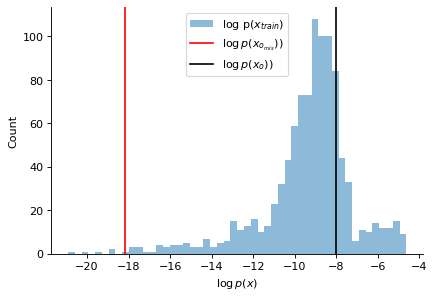

In [103]:
plt.figure(figsize=(6, 4), dpi=80)
plt.hist(
    log_probs_train,
    bins=50,
    alpha=0.5,
    label="log p($x_{train}$)",
)
plt.axvline(
    log_prob_xo_mis,
    color="red",
    label=r"$\log p(x_{o_{mis}})$)",
)
plt.axvline(log_prob_xo, color="k", label=r"$\log p(x_o)$)")
plt.ylabel("Count")
plt.xlabel(r"$\log p(x)$")
plt.legend()
plt.show()